<a href="https://colab.research.google.com/github/hafeez42/marketing_data_science/blob/master/Segmentation/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)


import seaborn as sns

In [ ]:
# import json file into colab
from google.colab import files
files.upload()

# setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# verifying json file content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s wholesale


ref                                                             title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------------  -----------------------------------------------  ------  -------------------  -------------  
irinachuchueva/russian-wholesale-electricity-market             Russian Wholesale Electricity Market                1MB  2020-03-03 20:12:28           2107  
binovi/wholesale-customers-data-set                              Wholesale customers Data Set                       7KB  2018-04-11 14:32:40           5186  
census/total-merchant-wholesalers-inventory-and-sales           Total Merchant Wholesalers Inventory and Sales      8KB  2019-12-06 09:14:41            337  
census/merchant-wholesalers-inventories-data                    Merchant Wholesalers Inventories Data              17KB  2019-12-07 01:02:26            149  
sahistapatel96/wholesale-customer-datacsv           

In [ ]:
# download the dataset
!kaggle datasets download -d binovi/wholesale-customers-data-set
# unzip files
!unzip \*.zip

  0% 0.00/6.85k [00:00<?, ?B/s]
100% 6.85k/6.85k [00:00<00:00, 13.3MB/s]
Archive:  wholesale-customers-data-set.zip
  inflating: Wholesale customers data.csv  


In [ ]:
data = pd.read_csv('Wholesale customers data.csv', engine='python')

data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
data = data.drop(['Channel', 'Region'], axis = 1)

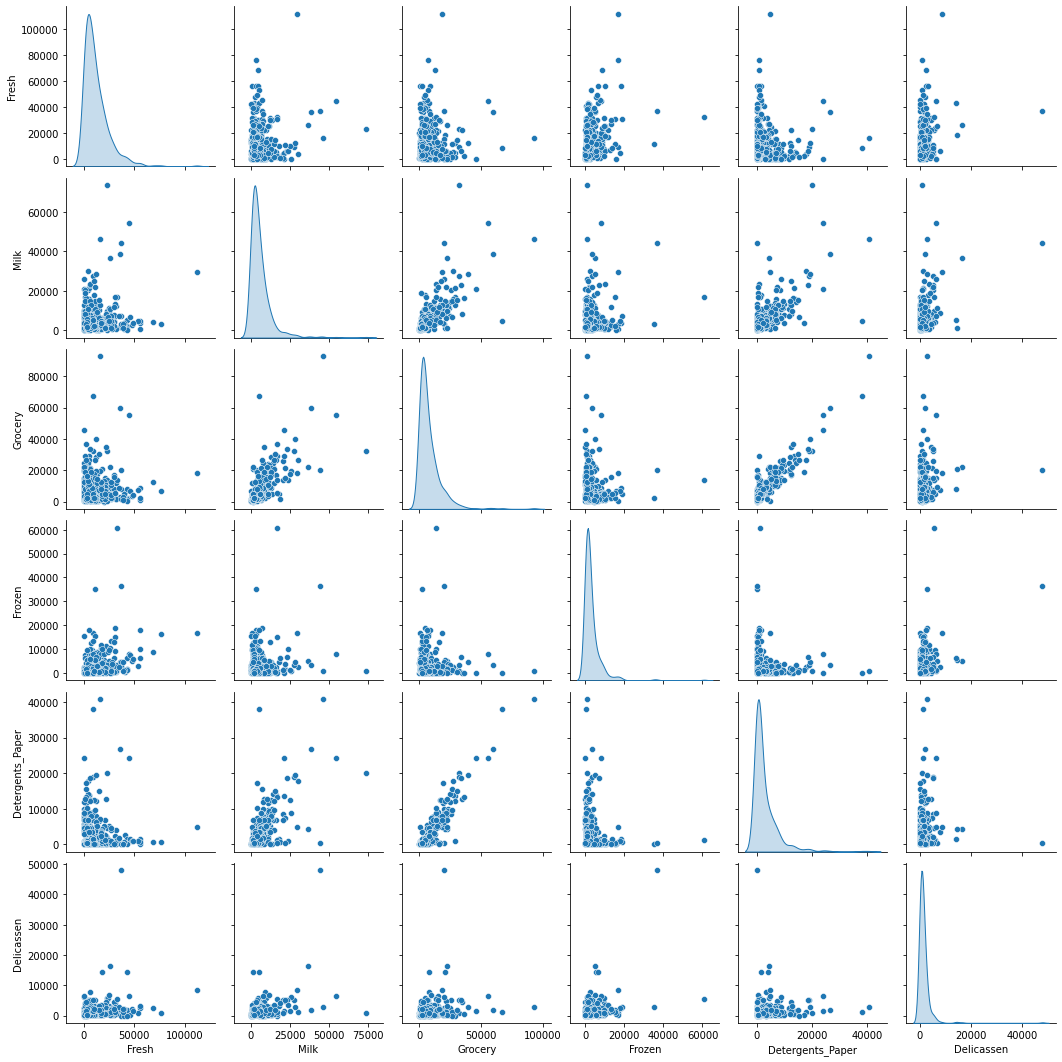

In [ ]:
# Plot the pairwise relationships between the variables
sns.pairplot(data, diag_kind='kde')

# Display the chart
plt.show()

Pairwise plot shows that our data is skewed (not normally distributed)

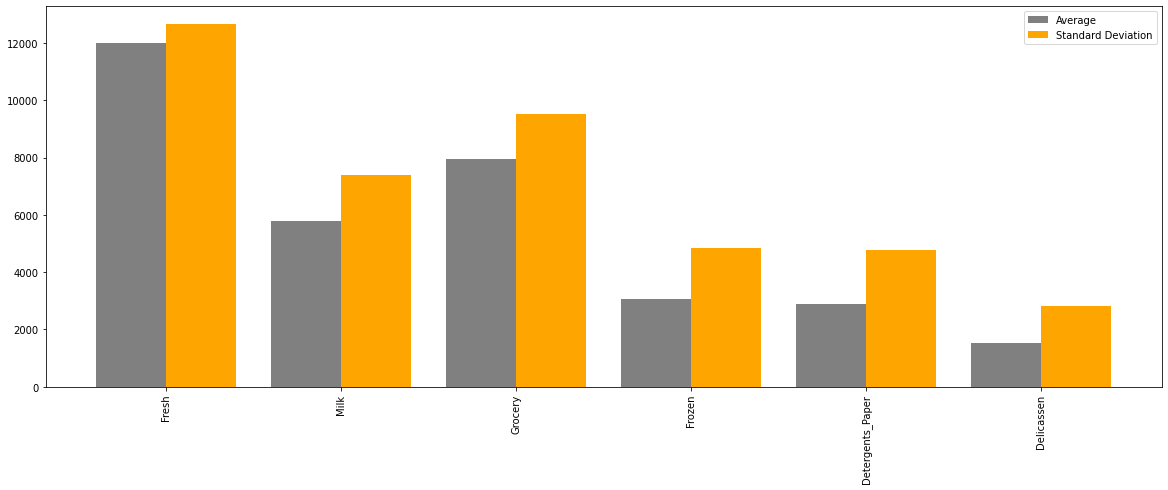

In [ ]:
# Create column names list and same length integer list
x_names = data.columns
x_ix = np.arange(data.shape[1])

averages = data.mean()
std_devs = data.std()

# Plot the averages data in gray and standard deviations in orange 
plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)

# Add x-axis labels and rotate
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)

# Add the legend and display the chart
plt.legend()
plt.show()

# K-Means
## Model Assumptions
K-means  works well when: 
 - data normally distributed
 - data is standartized ( mean = 0, std = 1)

## Normalizing Data


### Log Transformation
 normalizing data with log transformation

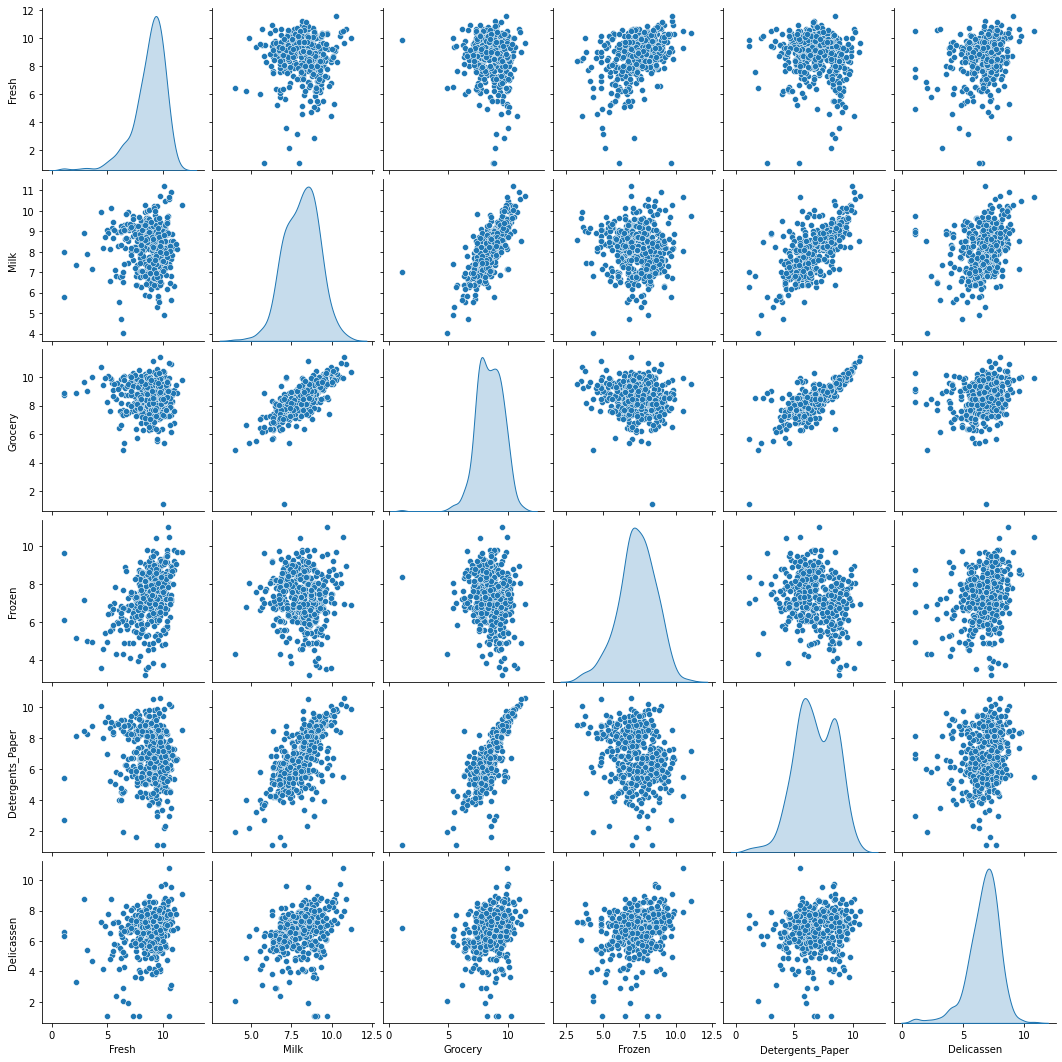

In [ ]:
data_log = np.log(data)

# plot the pairwise relationships between the variables
sns.pairplot(data_log, diag_kind='kde')

# Display the chart
plt.show()

top left variable still looks a little skewed

### Box-Cox Transformation

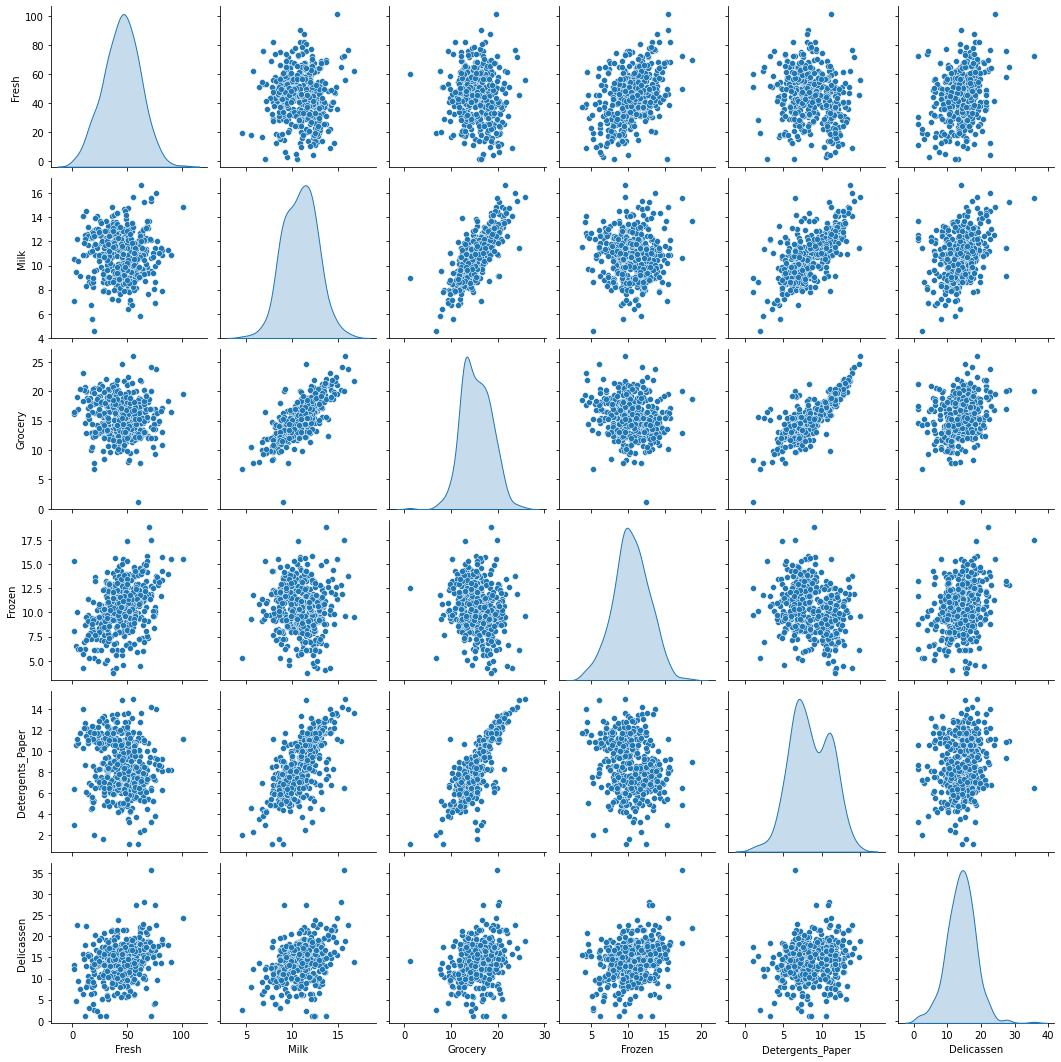

In [ ]:
from scipy import stats

def boxcox_it(x):
  x_boxcox, _ =  stats.boxcox(x)
  return x_boxcox

data_boxcox = data.apply(boxcox_it, axis = 0)

# plot the pairwise relationships between the variables
sns.pairplot(data_boxcox, diag_kind='kde')

# Display the chart
plt.show()


## Stardartization
### Scale the data
- substract column average from each column value
- divide each columns vaue by column stardard deviation

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(data_boxcox)

data_scaled = scaler.transform(data_boxcox)
data_scaled_df = pd.DataFrame(data = data_scaled,
                              index = data_boxcox.index,
                              columns = data_boxcox.columns)

data_scaled_df.agg(['mean', 'std']).round()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,-0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


# Elbow Criterion method
we use Elbow criterion method to calculate number of segments. First, we'll iterate through a number of * K* values. Then, run clustering for each on the same data. Within each run we calculate sum of squared errors (SSE) to see how much it is reduced as we add more segments.
Finally, we are going to plot SSE against K to identify *Elbow* - diminishing incremental improvements in error reduction

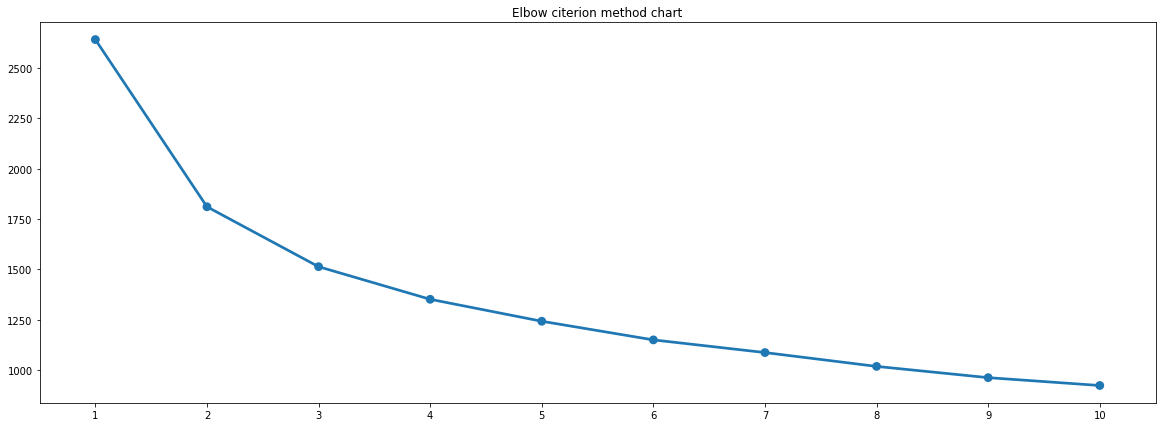

In [ ]:
sse = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(data_scaled_df)
  sse[k] = kmeans.inertia_

plt.title('Elbow citerion method chart')
sns.pointplot(x=list(sse.keys()), y =list(sse.values()))
plt.show()

# Segmenation with K-mean

In [ ]:
from sklearn.cluster import KMeans

k= 4
kmeans = KMeans(n_clusters = k)

kmeans.fit(data_scaled_df)

data_kmeans = data.assign(segment = kmeans.labels_)

# NMF - non-negative matrix factorization
 works well on raw data, especially if the matrix is *sparse*

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(k)
nmf.fit(data)

components = pd.DataFrame(nmf.components_, columns = data.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [ ]:
# extracting segment assignment

segment_weights = pd.DataFrame(nmf.transform(data), columns = components.index)
segment_weights.index = data.index
data_nmf = data.assign(segment = segment_weights.idxmax(axis=1))

# Exploring Segments

## K-means segmentation attributes

In [ ]:
""" Analyse K-mean segmentation attributes"""
kmeans_averages = data_kmeans.groupby(['segment']).mean().round(0)
print(kmeans_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0        26312.0   5489.0   5228.0  8342.0             830.0      3212.0
1        10229.0   1891.0   2500.0  2403.0             449.0       741.0
2        10453.0  12717.0  17723.0  1940.0            7684.0      2394.0
3         3618.0   6645.0  11296.0   703.0            4675.0       576.0


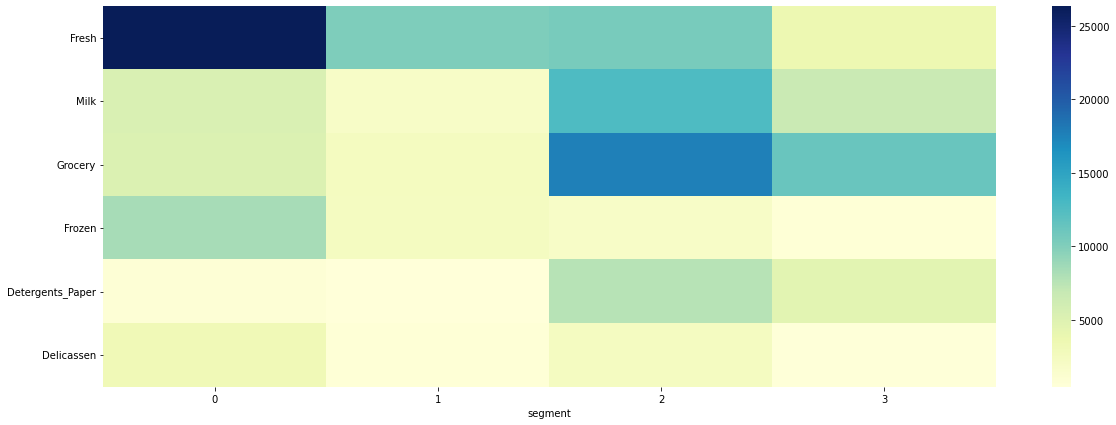

In [ ]:
""" Plot K-mean segmentation attributes"""
sns.heatmap(kmeans_averages.T, cmap='YlGnBu')
plt.show()

## NMF segmentation attributes

In [ ]:
""" Analyse NMF segmentation attributes"""
nmf_averages = data_nmf.groupby(['segment']).mean().round(0)
print(kmeans_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0        26312.0   5489.0   5228.0  8342.0             830.0      3212.0
1        10229.0   1891.0   2500.0  2403.0             449.0       741.0
2        10453.0  12717.0  17723.0  1940.0            7684.0      2394.0
3         3618.0   6645.0  11296.0   703.0            4675.0       576.0


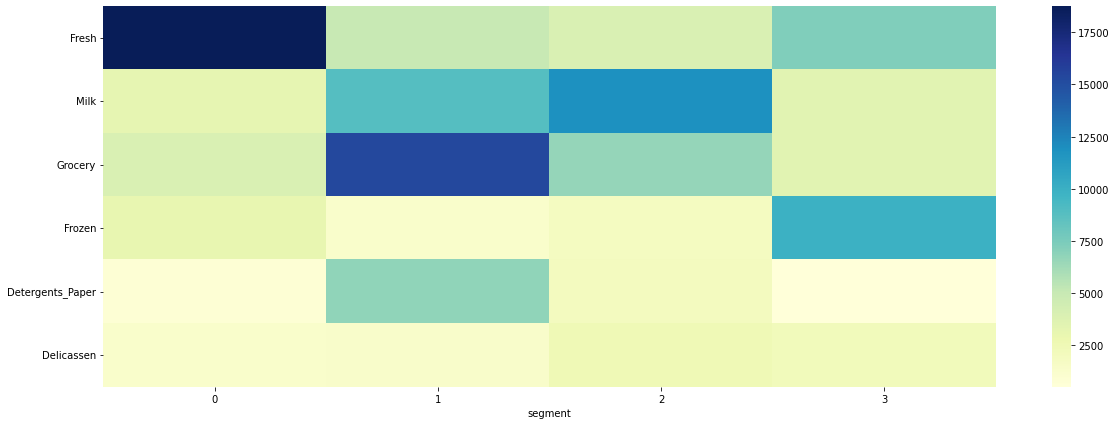

In [ ]:
""" Plot NMF segmentation attributes"""
sns.heatmap(nmf_averages.T, cmap='YlGnBu')
plt.show()